### Source determination through NOAA HYSPLIT trajectory model
      

<img src="https://www.ready.noaa.gov/images/ready/hysplit_logo_rec_165px.png" width=300 alt="NOAA logo" />       <img src="https://firms.modaps.eosdis.nasa.gov/images/touch/icon-192x192.png" width=150 alt="NASA logo" />



## **HYSPLIT models simulate the dispersion and trajectory of substances transported and dispersed through our atmosphere, over local to global scales.**

### **A common application is a back trajectory analysis to determine the origin of air masses and establish source-receptor relationships.** 

In [6]:
# import libraries
import xarray as xr   # for data storage and processing
import numpy as np    # for data storage and processig
import pandas as pd   # for data storage and processig
import act
from datetime import datetime  # for formating date and time
import matplotlib.pyplot as plt

In [7]:
# define the function to read the HYSPLIT model output file
def read_hysplit(filename, base_year=2000):
    """
    Reads an input HYSPLIT trajectory for plotting in ACT.
    Parameters
    ----------
    filename: str
        The input file name.
    base_year: int
        The first year of the century in which the data are contained.
    Returns
    -------
    ds: xarray Dataset
        The ACT dataset containing the HYSPLIT trajectories
    """
    ds = xr.Dataset({})
    num_lines = 0
    with open(filename) as filebuf:
        num_grids = int(filebuf.readline().split()[0])
        num_lines += 1
        grid_times = []
        grid_names = []
        forecast_hours = np.zeros(num_grids)
        for i in range(num_grids):
            data = filebuf.readline().split()
            num_lines += 1
            grid_names.append(data[0])
            grid_times.append(
                datetime(
                    year=(int(data[1]) + base_year),
                    month=int(data[2]),
                    day=int(data[3]),
                    hour=int(data[4]),
                )
            )
            forecast_hours[i] = int(data[5])
        ds["grid_forecast_hour"] = xr.DataArray(forecast_hours, dims=["num_grids"])
        ds["grid_forecast_hour"].attrs["standard_name"] = "Grid forecast hour"
        ds["grid_forecast_hour"].attrs["units"] = "Hour [UTC]"
        ds["grid_times"] = xr.DataArray(np.array(grid_times), dims=["num_grids"])
        data_line = filebuf.readline().split()
        num_lines += 1
        ds.attrs["trajectory_direction"] = data_line[1]
        ds.attrs["vertical_motion_calculation_method"] = data_line[2]
        num_traj = int(data_line[0])
        traj_times = []
        start_lats = np.zeros(num_traj)
        start_lons = np.zeros(num_traj)
        start_alt = np.zeros(num_traj)
        for i in range(num_traj):
            data = filebuf.readline().split()
            num_lines += 1
            traj_times.append(
                datetime(
                    year=(base_year + int(data[0])),
                    month=int(data[1]),
                    day=int(data[2]),
                    hour=int(data[3]),
                )
            )
            start_lats[i] = float(data[4])
            start_lons[i] = float(data[5])
            start_alt[i] = float(data[6])
        ds["start_latitude"] = xr.DataArray(start_lats, dims=["num_trajectories"])
        ds["start_latitude"].attrs["long_name"] = "Trajectory start latitude"
        ds["start_latitude"].attrs["units"] = "degree"
        ds["start_longitude"] = xr.DataArray(start_lats, dims=["num_trajectories"])
        ds["start_longitude"].attrs["long_name"] = "Trajectory start longitude"
        ds["start_longitude"].attrs["units"] = "degree"
        ds["start_altitude"] = xr.DataArray(start_alt, dims=["num_trajectories"])
        ds["start_altitude"].attrs["long_name"] = "Trajectory start altitude"
        ds["start_altitude"].attrs["units"] = "degree"
        data = filebuf.readline().split()
        num_lines += 1
        var_list = [
            "trajectory_number",
            "grid_number",
            "year",
            "month",
            "day",
            "hour",
            "minute",
            "forecast_hour",
            "age",
            "lat",
            "lon",
            "alt",
        ]
        for variable in data[1:]:
            var_list.append(variable)
        input_df = pd.read_csv(
            filebuf, sep=r'\s+', index_col=False, names=var_list, skiprows=1
        )  # noqa W605
        input_df['year'] = base_year + input_df['year']
        input_df['year'] = input_df['year'].astype(int)
        input_df['month'] = input_df['month'].astype(int)
        input_df['day'] = input_df['day'].astype(int)
        input_df['hour'] = input_df['hour'].astype(int)
        input_df['minute'] = input_df['minute'].astype(int)
        input_df['time'] = pd.to_datetime(
            input_df[["year", "month", "day", "hour", "minute"]], format='%y%m%d%H%M'
        )
        input_df = input_df.set_index("time")
        del input_df["year"]
        del input_df["month"]
        del input_df["day"]
        del input_df["hour"]
        del input_df["minute"]
        ds = ds.merge(input_df.to_xarray())
        ds.attrs['datastream'] = 'hysplit'
        ds["trajectory_number"].attrs["standard_name"] = "Trajectory number"
        ds["trajectory_number"].attrs["units"] = "1"
        ds["grid_number"].attrs["standard_name"] = "Grid number"
        ds["grid_number"].attrs["units"] = "1"
        ds["age"].attrs["standard_name"] = "Grid number"
        ds["age"].attrs["units"] = "1"
        ds["lat"].attrs["standard_name"] = "Latitude"
        ds["lat"].attrs["units"] = "degree"
        ds["lon"].attrs["standard_name"] = "Longitude"
        ds["lon"].attrs["units"] = "degree"
        ds["alt"].attrs["standard_name"] = "Altitude"
        ds["alt"].attrs["units"] = "meter"
    return ds

## Plotting HYSPLIT back trajectory and compare with NASA firemap

### Case 1: Jan 8th, 2022

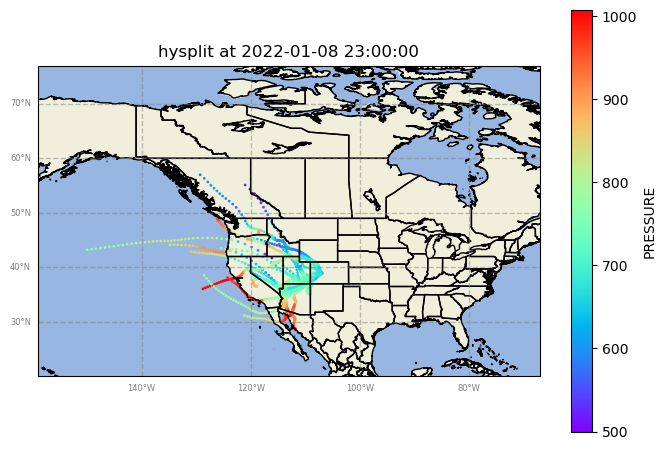

In [8]:
# Load the data
filename = 'guc_010822.txt'
ds = read_hysplit(filename)

# Use the GeographicPlotDisplay object to make the plot
disp = act.plotting.GeographicPlotDisplay(ds)
ax = disp.geoplot('PRESSURE', cartopy_feature=['STATES', 'OCEAN', 'LAND'], s = 1)
ax.set_xlim([-159, -67])
ax.set_ylim([20, 77])
plt.show()

<img src="images/firemap_010822.png" width = 900 height = 600 alt="Project Pythia Logo"></img>

# Fire Map Link

![NASA FIRMS Fire Map](https://firms.modaps.eosdis.nasa.gov/images/touch/icon-192x192.png)

[Click here to view the interactive map](https://firms.modaps.eosdis.nasa.gov/map/#d:24hrs;@30.0,-2.5,3.5z)




### Case 2: Jan 25th, 2022

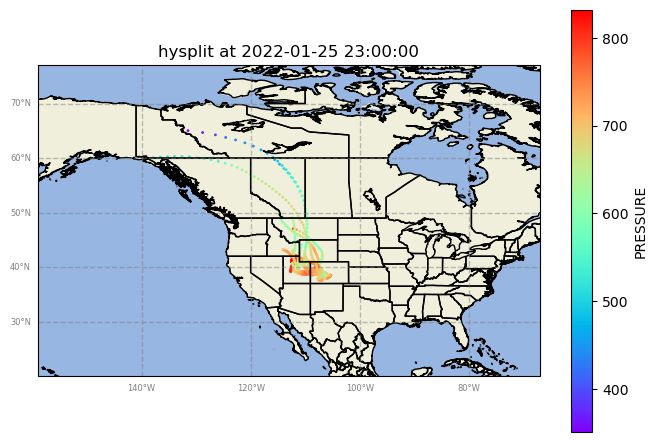

In [65]:
# Load the data
filename = 'guc_012522.txt'
ds = read_hysplit(filename)

# Use the GeographicPlotDisplay object to make the plot
disp = act.plotting.GeographicPlotDisplay(ds)
ax = disp.geoplot('PRESSURE', cartopy_feature=['STATES', 'OCEAN', 'LAND'], s = 1)
ax.set_xlim([-159, -67])
ax.set_ylim([20, 77])
plt.show()

<img src="images/firemap_012522.png" width = 900 height = 600 alt="Project Pythia Logo"></img>

### Case 3: Apr 3rd, 2023

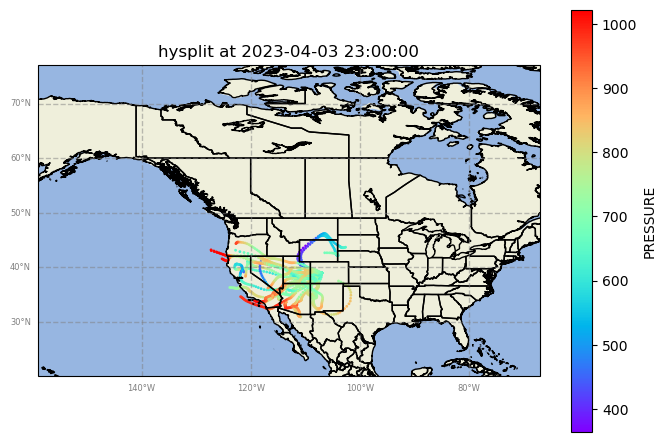

In [9]:
# Load the data
filename = 'guc_040323.txt'
ds = read_hysplit(filename)

# Use the GeographicPlotDisplay object to make the plot
disp = act.plotting.GeographicPlotDisplay(ds)
ax = disp.geoplot('PRESSURE', cartopy_feature=['STATES', 'OCEAN', 'LAND'], s = 1)
ax.set_xlim([-159, -67])
ax.set_ylim([20, 77])
plt.show()

<img src="images/firemap_040323.png" width = 900 height = 600 alt="NASA firemap 040323"></img>

<iframe src="data/home/jlai/sail-cookbook/notebooks/ARM_smps_data.html" width="100%" height="600px"></iframe>


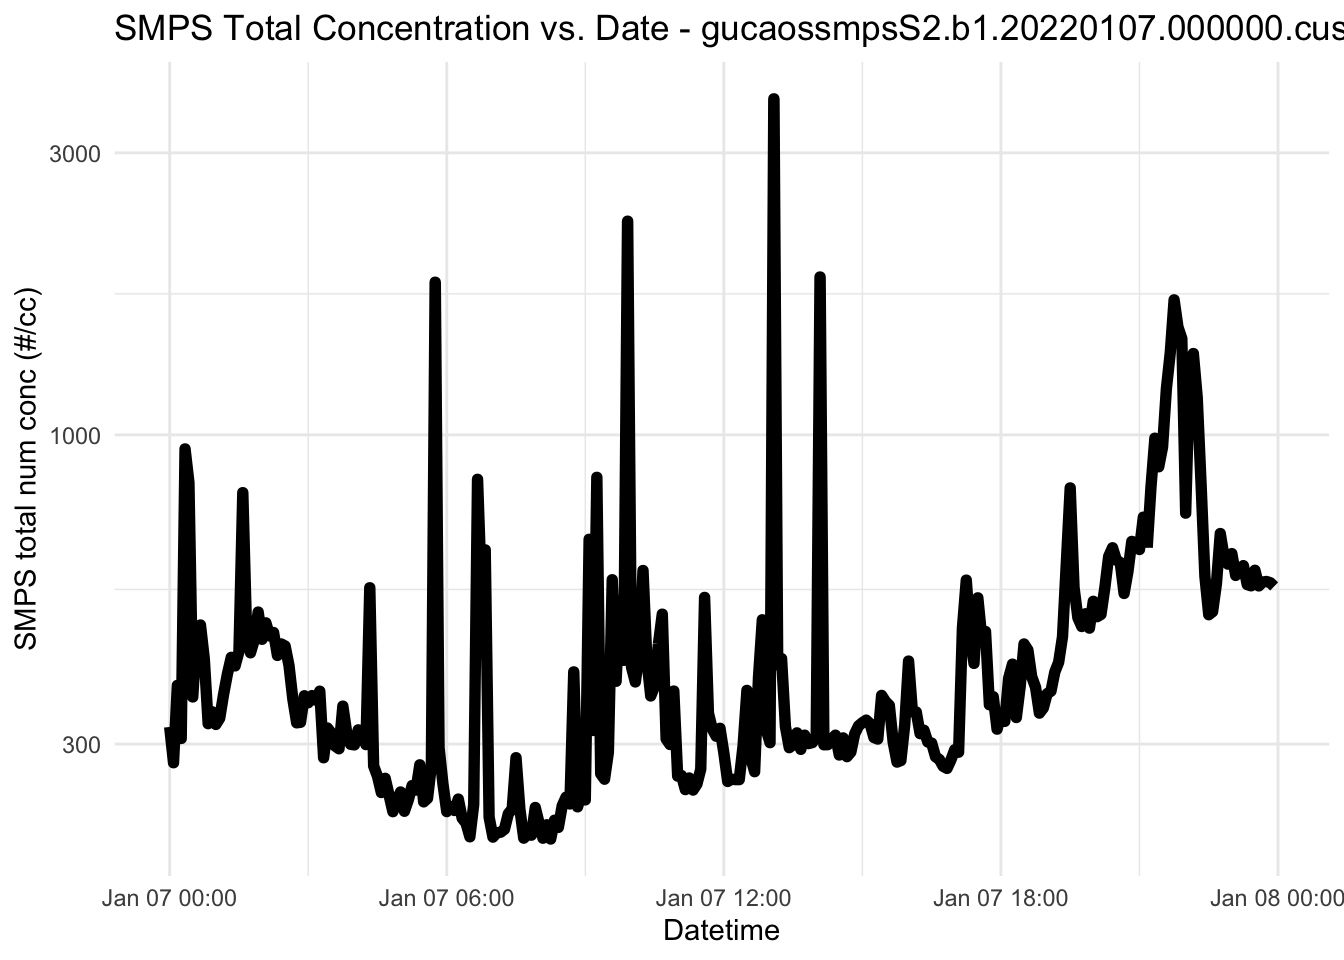
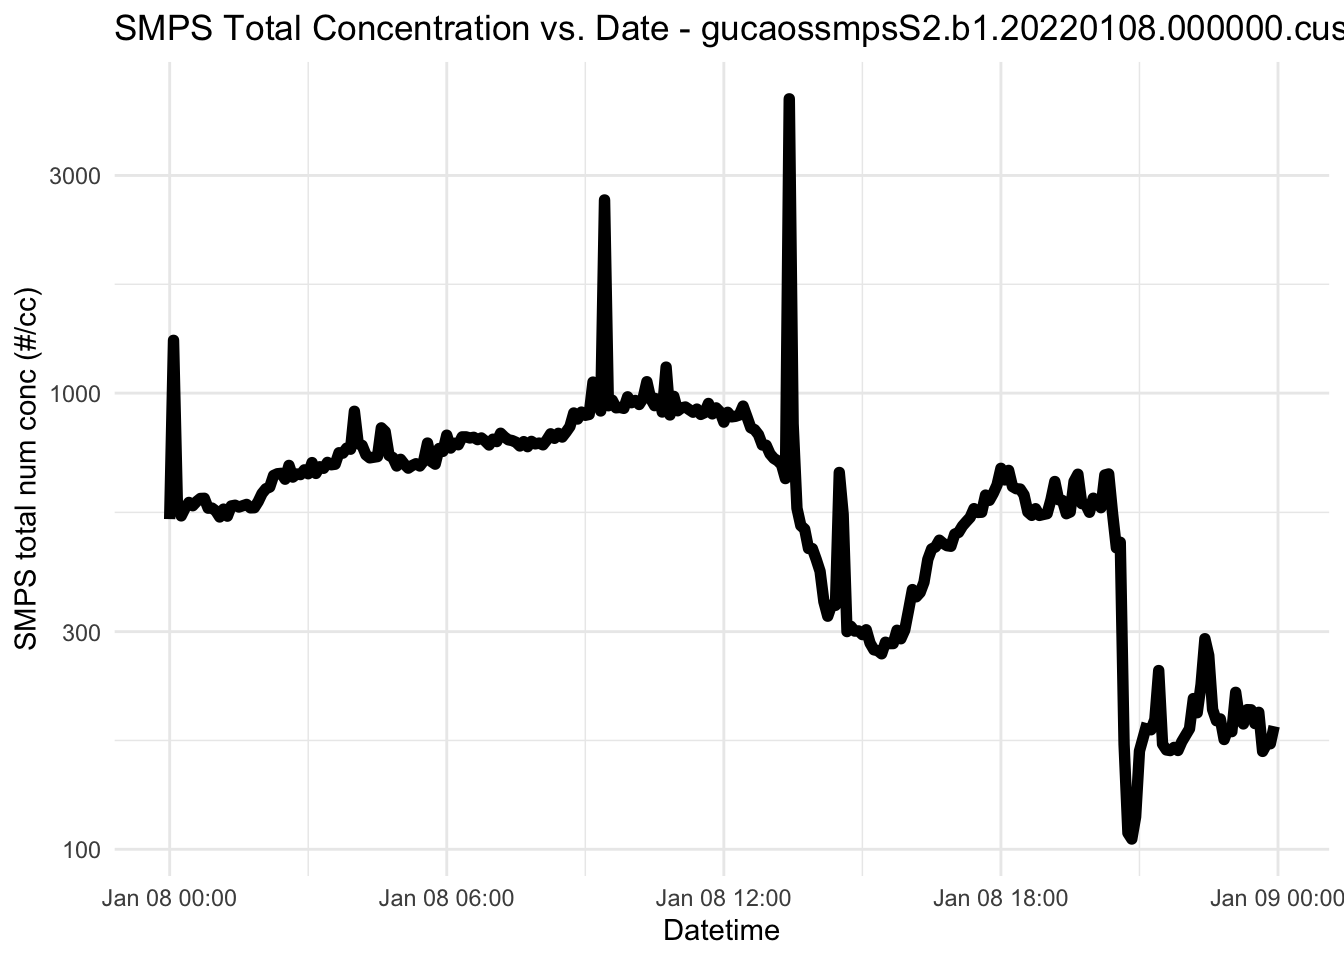
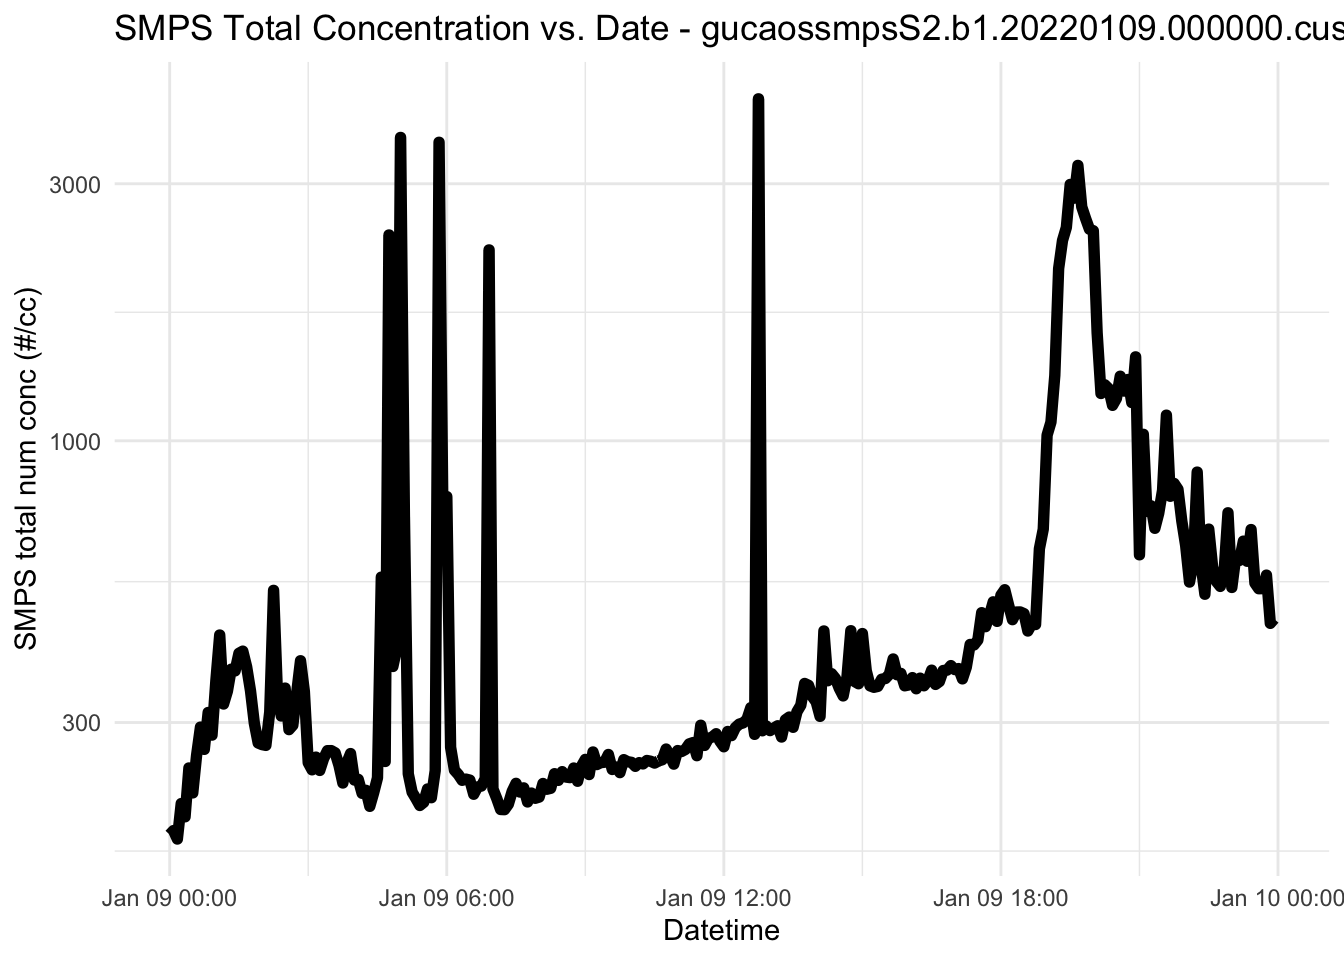
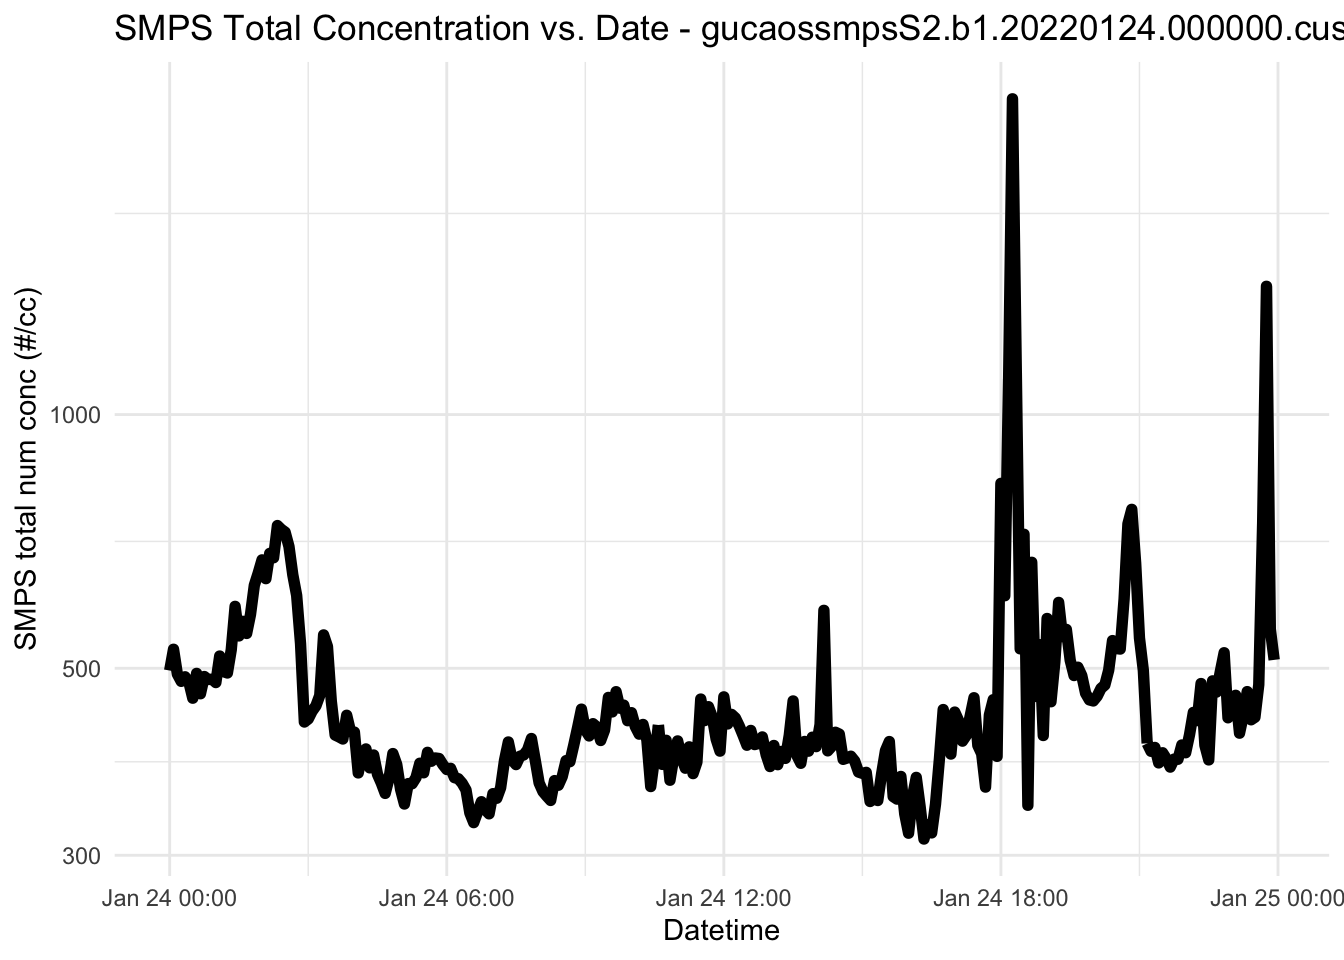
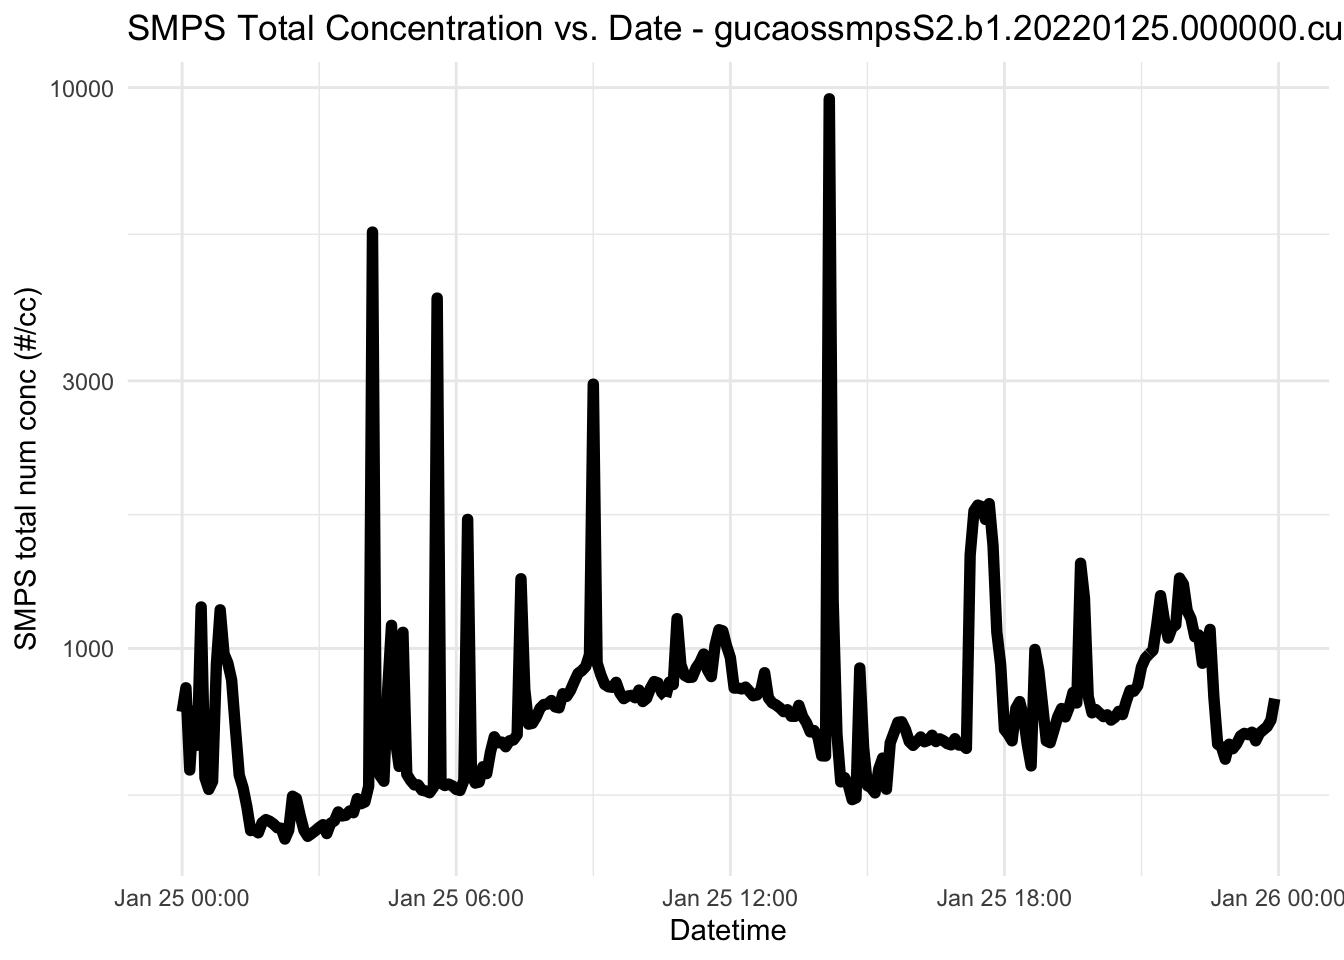
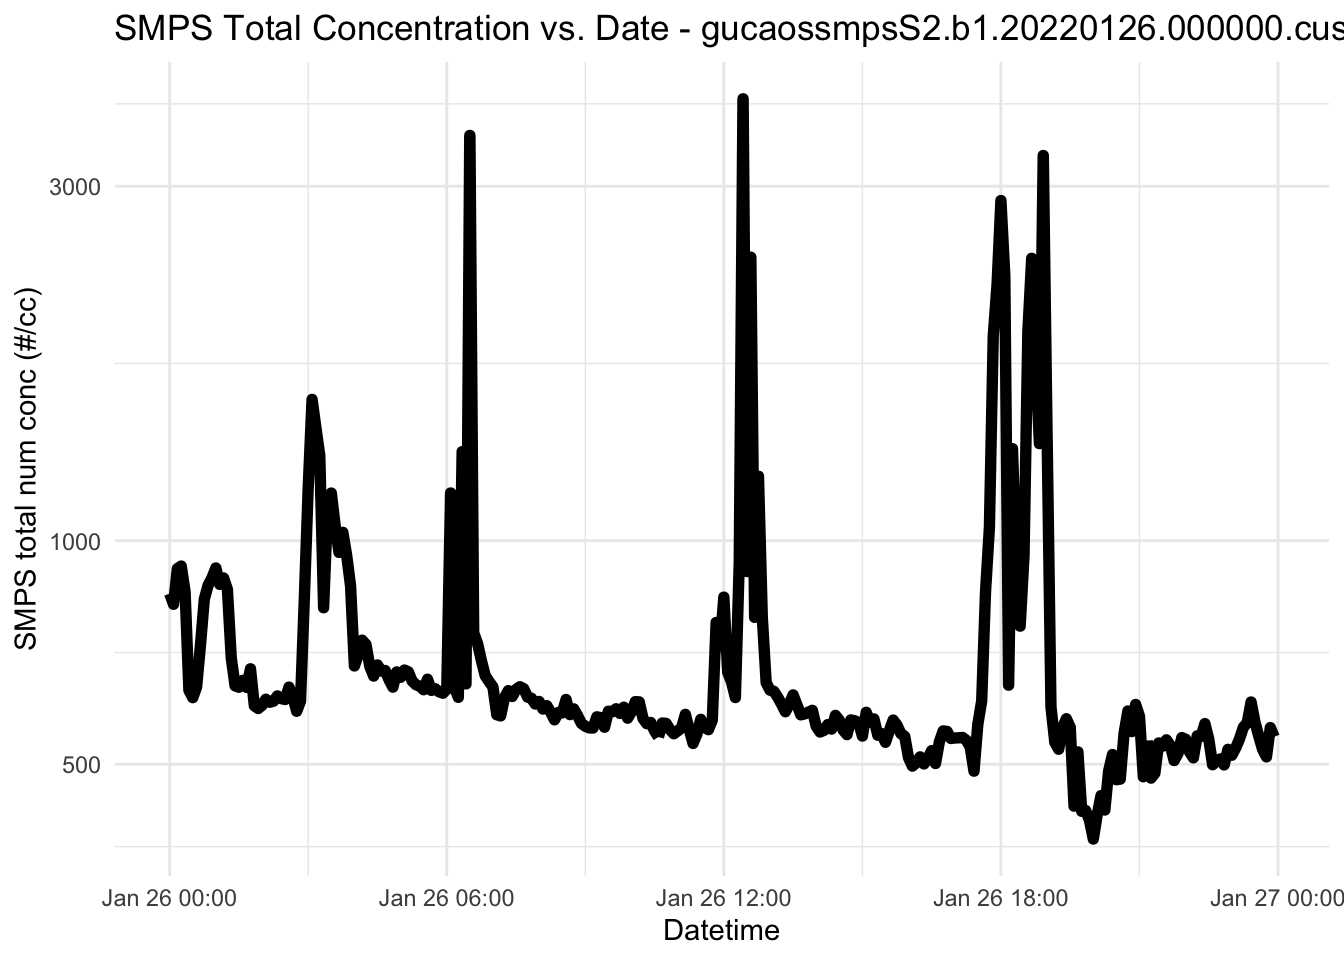
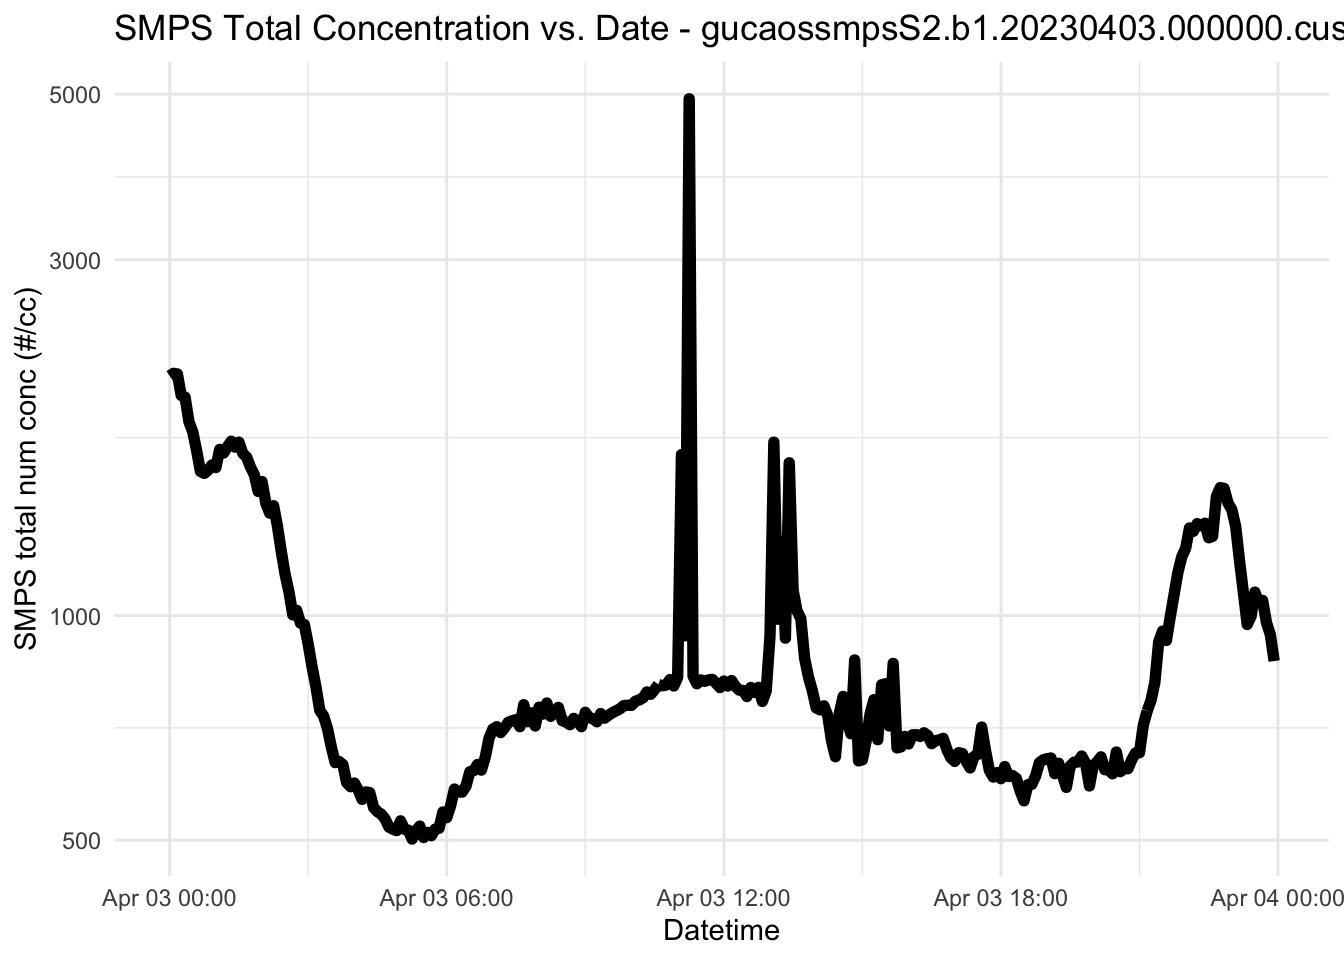
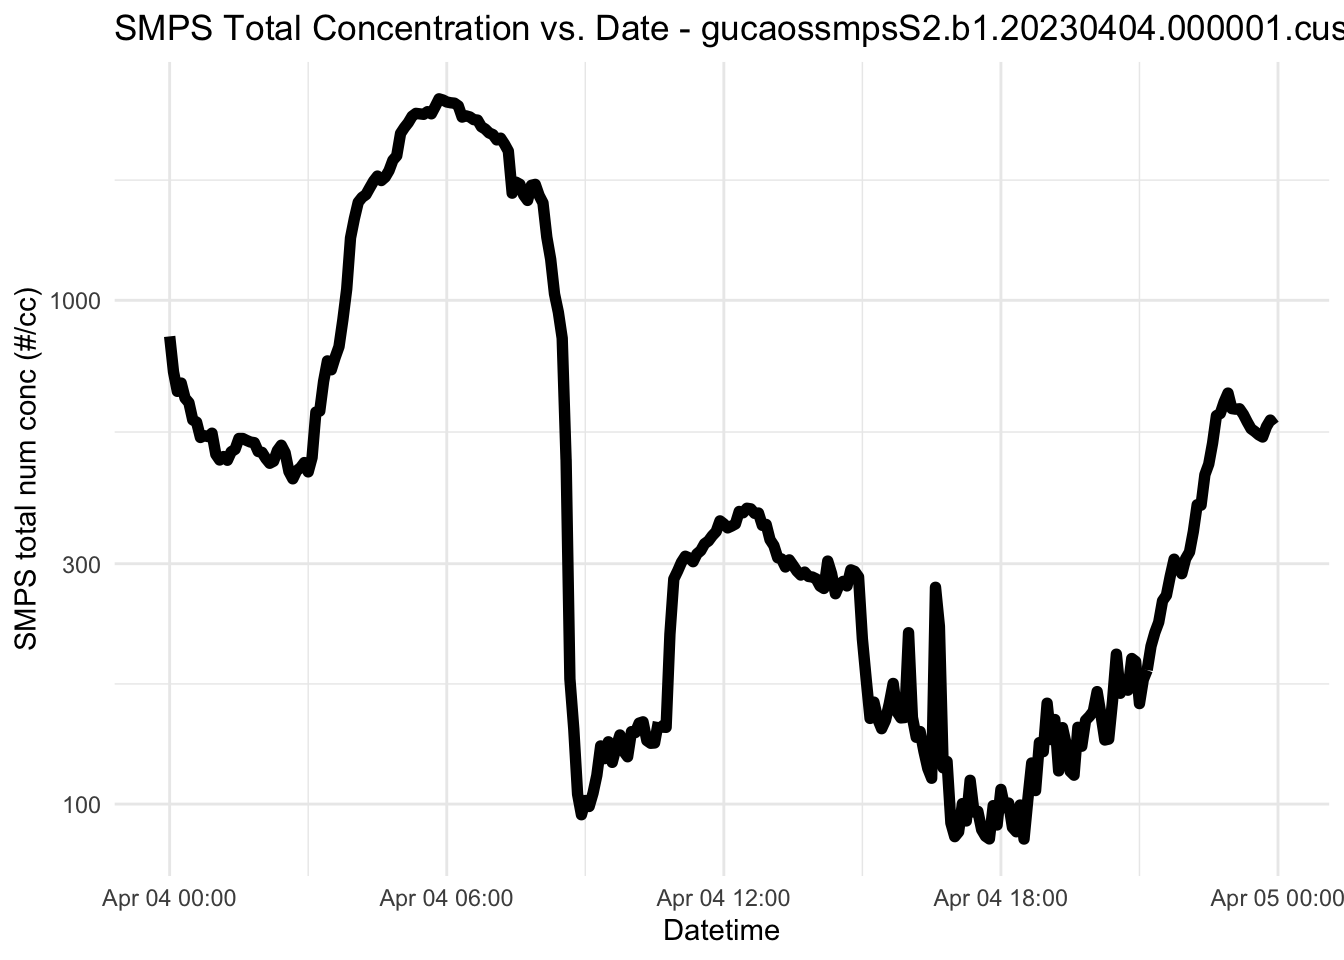

In [39]:
from IPython.display import display, HTML

# Adjust the path to your HTML file accordingly
file_path = "ARM_smps_data.html"

# Read the content of the HTML file
with open(file_path, 'r') as file:
    html_content = file.read()

# Display the HTML content
display(HTML(html_content))
